# **Business Intution**

You work for a social media platform. Your task is to create a solution using deep learning to discern whether a post is holiday-related in an effort to better monetize the platform.

**Task**

You are given the following six categories. You are required to classify the images in the dataset based on these categories.

Miscellaneous

Christmas_Tree

Jacket

Candle

Airplane

Snowman

**Data description**

This data set consists of the following two columns:

| Column Name | Description |
| --- | --- |
| Image | Name of image |
| Class | Category of image |

The data folder consists of two folders and one .csv file. The details are as follows:

train: Contains 6469 images for 6 classes

test: Contains 3489 images

train.csv: 3489 x 2

**Submission format**

Image,Class

image3476.jpg,Miscellaneous

image5198.jpg,Candle

image4183.jpg,Snowman

image1806.jpg,Miscellaneous

image7831.jpg,Miscellaneous

**Evaluation metric**

$ score = {100* f1\_score(actual\_values,predicted\_values,average = 'weighted')} $

Note: To avoid any discrepancies in the scoring, ensure all the index column (Image) values in the submitted file match the values in the provided test folder.

# Import the Required Packages

In [1]:
import os.path, sys, math
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from PIL import Image
from imgaug import augmenters as iaa
import warnings
import random as rn
from keras import backend as K
import tensorflow as tf
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(style = 'whitegrid')

In [2]:
def random_seed(num):
    np.random.seed(num)
    rn.seed(num)
    try:
        tf.random.set_seed(num)
        return(f"Info: Tensorflow Version {tf.__version__}")
    except:
          tf.set_random_seed(num)
          return(f"Info: Tensorflow Version {tf.__version__}")
random_seed(30)

'Info: Tensorflow Version 2.4.0'

# Load the Datasets

In [3]:
def path(path_to_train):
    for dirname, _, filenames in os.walk(path_to_train):
        for filename in filenames:
            return os.path.join(dirname, filename)
path('D:/DataSets/dataset/train/')

'D:/DataSets/dataset/train/image1.jpg'

In [4]:
train = pd.read_csv('D:/DataSets/dataset/train.csv')
train.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


# Load an image to check

In [5]:
def load_img():
    img = cv2.imread('D:/DataSets/dataset/train/image1.jpg').astype(np.float32) / 255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [6]:
def display_img(img):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.imshow(img)

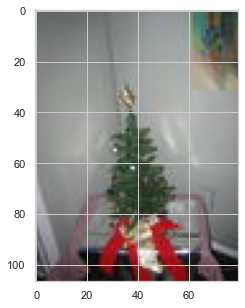

In [7]:
i = load_img()
display_img(i)

In [8]:
i.shape

(107, 80, 3)

# Basic EDA

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6469 entries, 0 to 6468
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   6469 non-null   object
 1   Class   6469 non-null   object
dtypes: object(2)
memory usage: 101.2+ KB


In [10]:
train.isnull().any()

Image    False
Class    False
dtype: bool

In [11]:
train.describe()

,Image,Class
count,6469,6469
unique,6469,6
top,image751.jpg,Miscellaneous
freq,1,2801


In [12]:
train['Class'].value_counts()

Miscellaneous     2801
Christmas_Tree    1539
Jacket             640
Candle             593
Airplane           535
Snowman            361
Name: Class, dtype: int64

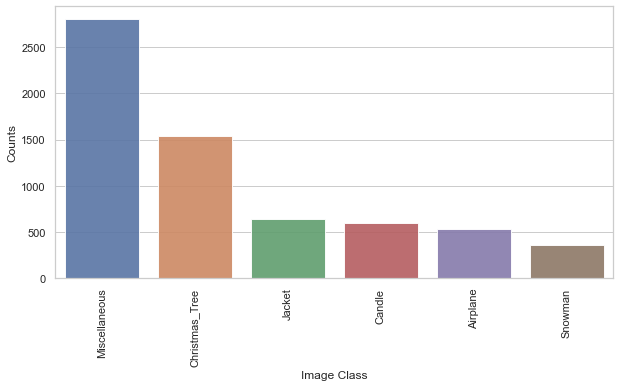

In [13]:
label_counts = train.Class.value_counts()
plt.figure(figsize = (10,5))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Class', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

# Split the DataFrame

In [14]:
from sklearn.model_selection import train_test_split

train_df,test_df = train_test_split(train,test_size=.15,stratify=train.Class.values,shuffle=True)
train_df.reset_index(inplace=True,drop=True)
test_df.reset_index(inplace=True,drop=True)

In [15]:
train_df.head()

,Image,Class
0,image7902.jpg,Snowman
1,image2038.jpg,Miscellaneous
2,image2339.jpg,Christmas_Tree
3,image1151.jpg,Snowman
4,image7775.jpg,Miscellaneous


In [16]:
test_df.head()

,Image,Class
0,image8264.jpg,Miscellaneous
1,image1957.jpg,Jacket
2,image6845.jpg,Miscellaneous
3,image9250.jpg,Candle
4,image8661.jpg,Airplane


# Import the Libraries for model building

In [17]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from keras import optimizers
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

# Divide & Get the images for training Purpose

We will use tf.keras.preprocessing.image.ImageDataGenerator

In [18]:
train_image = 'D:/DataSets/dataset/train/'

In [19]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [20]:
training_set = train_datagen.flow_from_dataframe(dataframe = train_df, directory = train_image, x_col='Image', y_col='Class',
                                                 weight_col=None, target_size=(299, 299), color_mode='rgb',
                                                 classes=None, class_mode='categorical', batch_size=32, shuffle=True, 
                                                 seed=None, save_to_dir=None, save_prefix='', 
                                                 save_format='png', subset=None, interpolation='nearest', 
                                                 validate_filenames=True)

Found 5498 validated image filenames belonging to 6 classes.


# Divide & Get the images for validation Purpose

In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
test_set = test_datagen.flow_from_dataframe(dataframe = test_df, directory = train_image, x_col='Image', y_col='Class',
                                            weight_col=None, target_size=(299, 299), color_mode='rgb',
                                            classes=None, class_mode='categorical', batch_size=32, shuffle=True, 
                                            seed=None, save_to_dir=None, save_prefix='', 
                                            save_format='png', subset=None, interpolation='nearest', 
                                            validate_filenames=True)

Found 971 validated image filenames belonging to 6 classes.


# **InceptionResNetV2  Model**

In [23]:
image_shape = [299, 299]

In [24]:
inception_model = tf.keras.applications.InceptionResNetV2(include_top=False,weights="imagenet",
                                                          input_shape=image_shape + [3])
for layer in inception_model.layers:
    layer.trainable = False  
x = Flatten()(inception_model.output)
prediction = Dense(6, activation='softmax')(x)
model = Model(inputs=inception_model.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_generate = model.fit(training_set,
                           steps_per_epoch=training_set.n//32,
                           epochs=10,
                           validation_data=test_set,
                           validation_steps=test_set.n//32)

# Plot the loss & the accuracy

In [ ]:
# Loss
plt.plot(model_generate.history['loss'], label='train loss')
plt.plot(model_generate.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [ ]:
# Accuracies
plt.plot(model_generate.history['accuracy'], label='train acc')
plt.plot(model_generate.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# **VGG19 Model**

In [29]:
vgg19_model = tf.keras.applications.VGG19(include_top=False,
                                          weights="imagenet",
                                          input_shape=image_shape + [3])

80142336/80134624 [==============================] - 9s 0us/step


In [31]:
add_model = Sequential()
add_model.add(Flatten(input_shape=vgg19_model.output_shape[1:]))
add_model.add(Dropout(0.3))
add_model.add(Dense(128, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(train_df.shape[1], activation='softmax'))
model = Model(inputs=vgg19_model.input, outputs=add_model(vgg19_model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0   

In [ ]:
batch_size = 8   
epochs = 15          

training_datagen = ImageDataGenerator(rotation_range=30, 
                                      width_shift_range=0.1, 
                                      height_shift_range=0.1,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True)
training_datagen.fit(train_df)

In [ ]:
history = model.fit_generator( train_datagen.flow(train_df, test_df, batch_size=batch_size),
                               steps_per_epoch=x_train.shape[0] // batch_size,
                               epochs=epochs,callbacks=callbacks("vgg19"))

# Plot the loss & the accuracy

In [ ]:
# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [ ]:
# Accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# **ResNet50 Model**

In [37]:
base_model2 = tf.keras.applications.ResNet50(include_top=False,
                                             weights="imagenet",
                                             input_shape=image_shape + [3])

94773248/94765736 [==============================] - 11s 0us/step


In [38]:
for layers in base_model2.layers[:-5]:
    layers.trainable=False

add_model2 = Sequential()
add_model2.add(base_model2)
add_model2.add(Conv2D(64,(3,3),activation='relu'))
add_model2.add(Conv2D(32,(3,3),activation='relu'))
add_model2.add(Flatten())
add_model2.add(Dropout(0.3))
add_model2.add(Dense(512, activation='relu'))
add_model2.add(Dropout(0.5))
add_model2.add(Dense(train_df.shape[1], activation='softmax'))
add_model2.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
add_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 10, 2048)      23587712  
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 8, 8, 64)          1179712   
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 6, 6, 32)          18464     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1152)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               590336    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [ ]:
history2 = add_model2.fit_generator(train_datagen.flow(train_df, test_df, batch_size=batch_size),
                               steps_per_epoch=x_train.shape[0] // batch_size,
                               epochs=epochs,callbacks=callbacks("NasNet"))

# Plot the loss & the accuracy

In [ ]:
# Loss
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [ ]:
# Accuracies
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')